In [1]:
import numpy as np
from scipy.integrate import solve_ivp, quad
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit


Para abrirlo en Colab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/SysBioengLab/IIQ2113-Chemical-reactor-design/blob/main/Tareas/Tarea1_solucion.ipynb)

# Pregunta 2

## A)

En esta pregunta, se les solicita calcular la energía de activación (Ea) y el factor de colisiones (A). Y además expresar la primera en kj/kmol.

In [2]:
### datos
T = np.array([288, 298, 308, 323]) # K
k = np.array([6804, 6570, 6033, 5434]) # M^-2 s^-1

Para poder estimar las cantidades solicitadas, se utiliza la metolodía basada en el gráfico de Arrhenius. Recordemos que la ecuación de Arrhenius tiene la siguiente expresión:
$$
k(T) = A \exp(\frac{Ea}{R T})
$$
Donde $A$ es el factor de colisiones, $Ea$ es la energía de activación, $R$ la constante de los gases ideales $8.314 \frac{J}{mol K}$ y $T$ la temperatura a evaluar en $K$.

Al aplicar el logaritmo natural a esta expresión, se puede linearizar la ecuación de forma de llegar a 
$$
\begin{align}
\ln(k) &= \ln\left(A \exp\left(\frac{Ea}{R T}\right)\right)\\
&= \ln(A) + \ln\left(\exp\left(\frac{Ea}{R T}\right)\right)\\
&= \ln(A) + \frac{Ea}{R} \frac{1}{T}
\end{align}
$$
De esta forma podemos encontrar los valores de las constantes mediante un ajuste lineal que relacione $\ln(k)$ y $1/T$. Este ajuste tiene la forma
$$
y = b + m x
$$
Donde $y = \ln(k)$, $b = \ln(A)$, $m = \frac{Ea}{R}$ y $x = \frac{1}{T}$. 

In [3]:
T_inv = 1/T
R = 8.314  # Constante R J/(mol*K)
ln_k = np.log(k)
### Ajuste lineal de los datos
m, b = np.polyfit(T_inv, ln_k, 1)

A = np.exp(b)  # Factor de colisiones
Ea = -m * R  # Energía de activación en J/mol = kj/kmol

print('Factor de colisiones (A):', A, 'M^-2 s^-1')
print('Energía de activación (Ea):', Ea, 'kJ/kmol') 

Factor de colisiones (A): 810.5306082973053 M^-2 s^-1
Energía de activación (Ea): -5132.209181295582 kJ/kmol


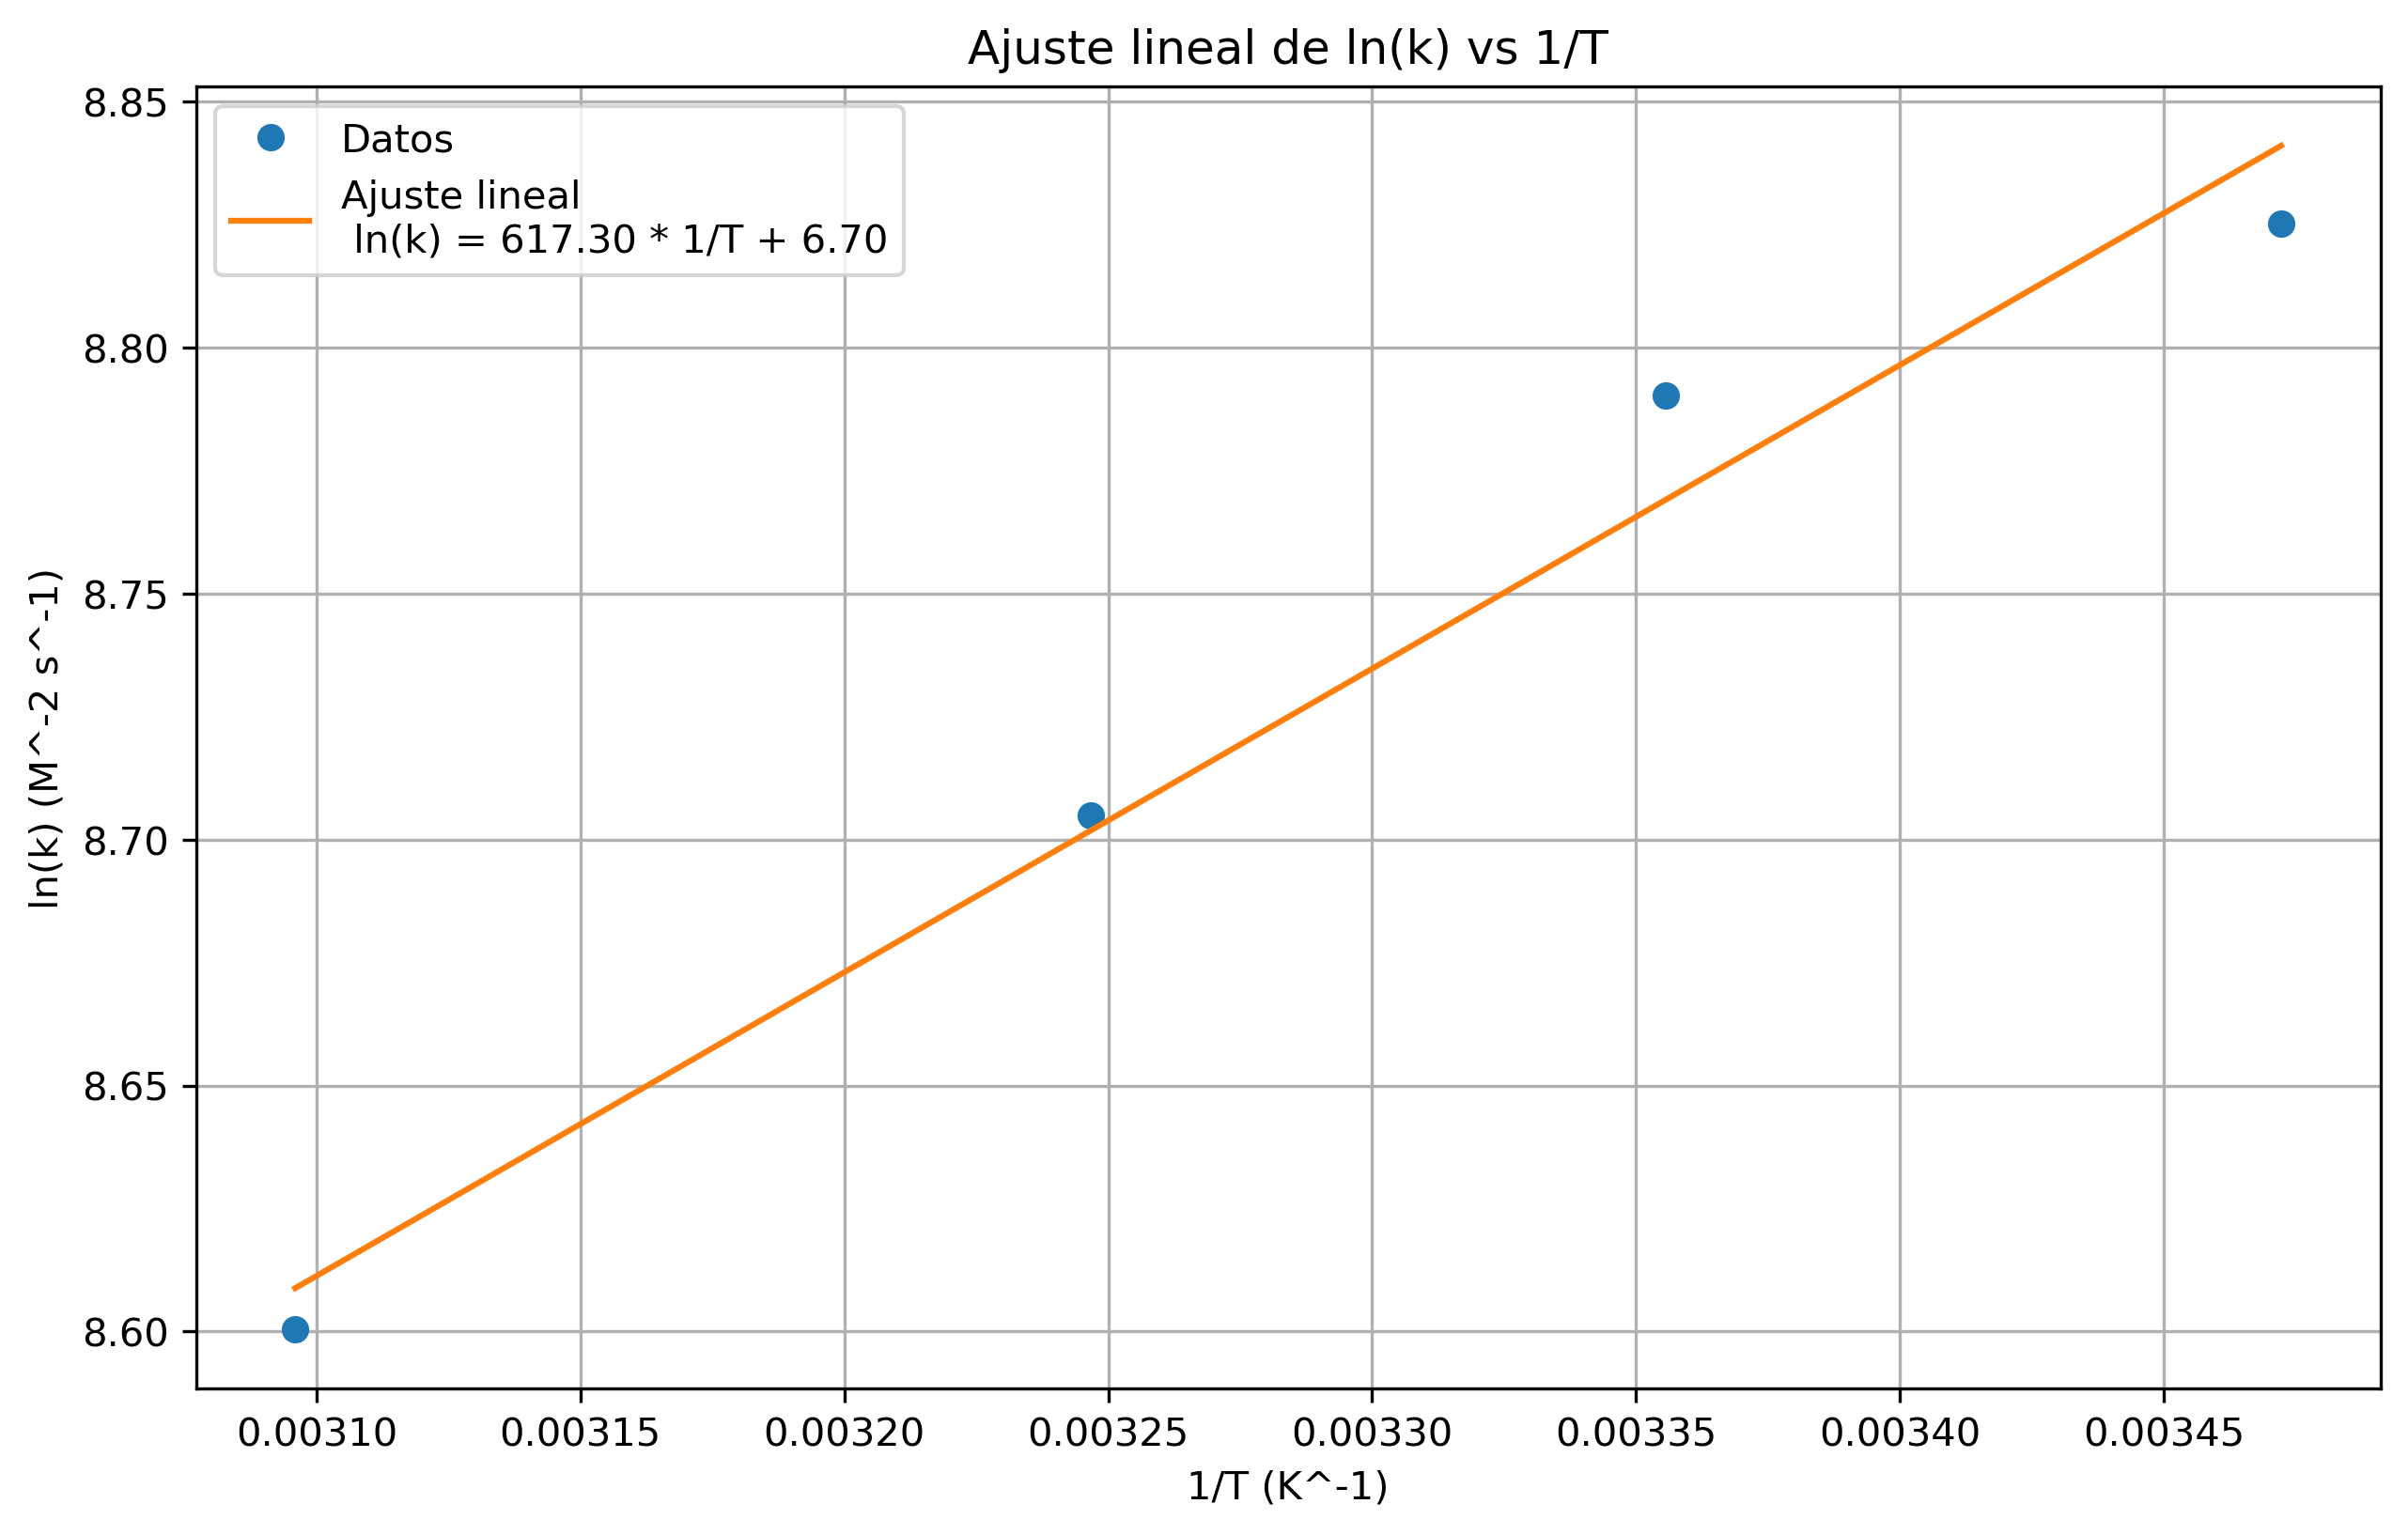

In [ ]:
# determinacion de endotermicidad o exotermicidad
plt.figure(figsize=(10, 6), # tamaño de la figura
           dpi = 300) # resolución de la figura
plt.plot(T_inv, ln_k, 'o', label = 'Datos')
plt.plot(T_inv, m * T_inv + b, label=f'Ajuste lineal\n ln(k) = {m:.2f} * 1/T + {b:.2f}') # línea de ajuste
plt.xlabel('1/T (K^-1)')
plt.ylabel('ln(k) (M^-2 s^-1)')
plt.title('Ajuste lineal de ln(k) vs 1/T')
plt.legend()
plt.grid()
plt.show()

Debido a que con aumentos de temperatura, la constante k disminuye, podemos decir que la reacción es exotérmica.

##  B. i)

En vista de que queremos evaluar las reacciones a diferentes temperaturas, debemos encontrar los valores de las constantes cinéticas a dichas temperatura (280 K y 320 K).

In [ ]:
def constante_velocidad(T,# temperatura en K
                  A, # factor de colisiones
                  Ea, # energia de activacion en j/mol
                  R): # constante de los gases en J/(mol*K)
    k = A * np.exp(-Ea / (R * T))
    return k

# Evaluación de la reacción a diferentes temperaturas
T_280 = 280  # K
T_320 = 320  # K
k_280 = constante_velocidad(T_280, A, Ea, R)
k_320 = constante_velocidad(T_320, A, Ea, R)
print('Constante cinética a 280 K:', k_280, 'M^-2 s^-1')
print('Constante cinética a 320 K:', k_320, 'M^-2 s^-1')

Constante cinética a 280 K: 7349.018708277842 M^-2 s^-1
Constante cinética a 320 K: 5578.877962048465 M^-2 s^-1


A partir de estos valores, es posible simular la evolución de las concentraciones mediante resolver el sistema de ecuaciones de forma numérica. Para esto se tiene el siguiente procedimiento:

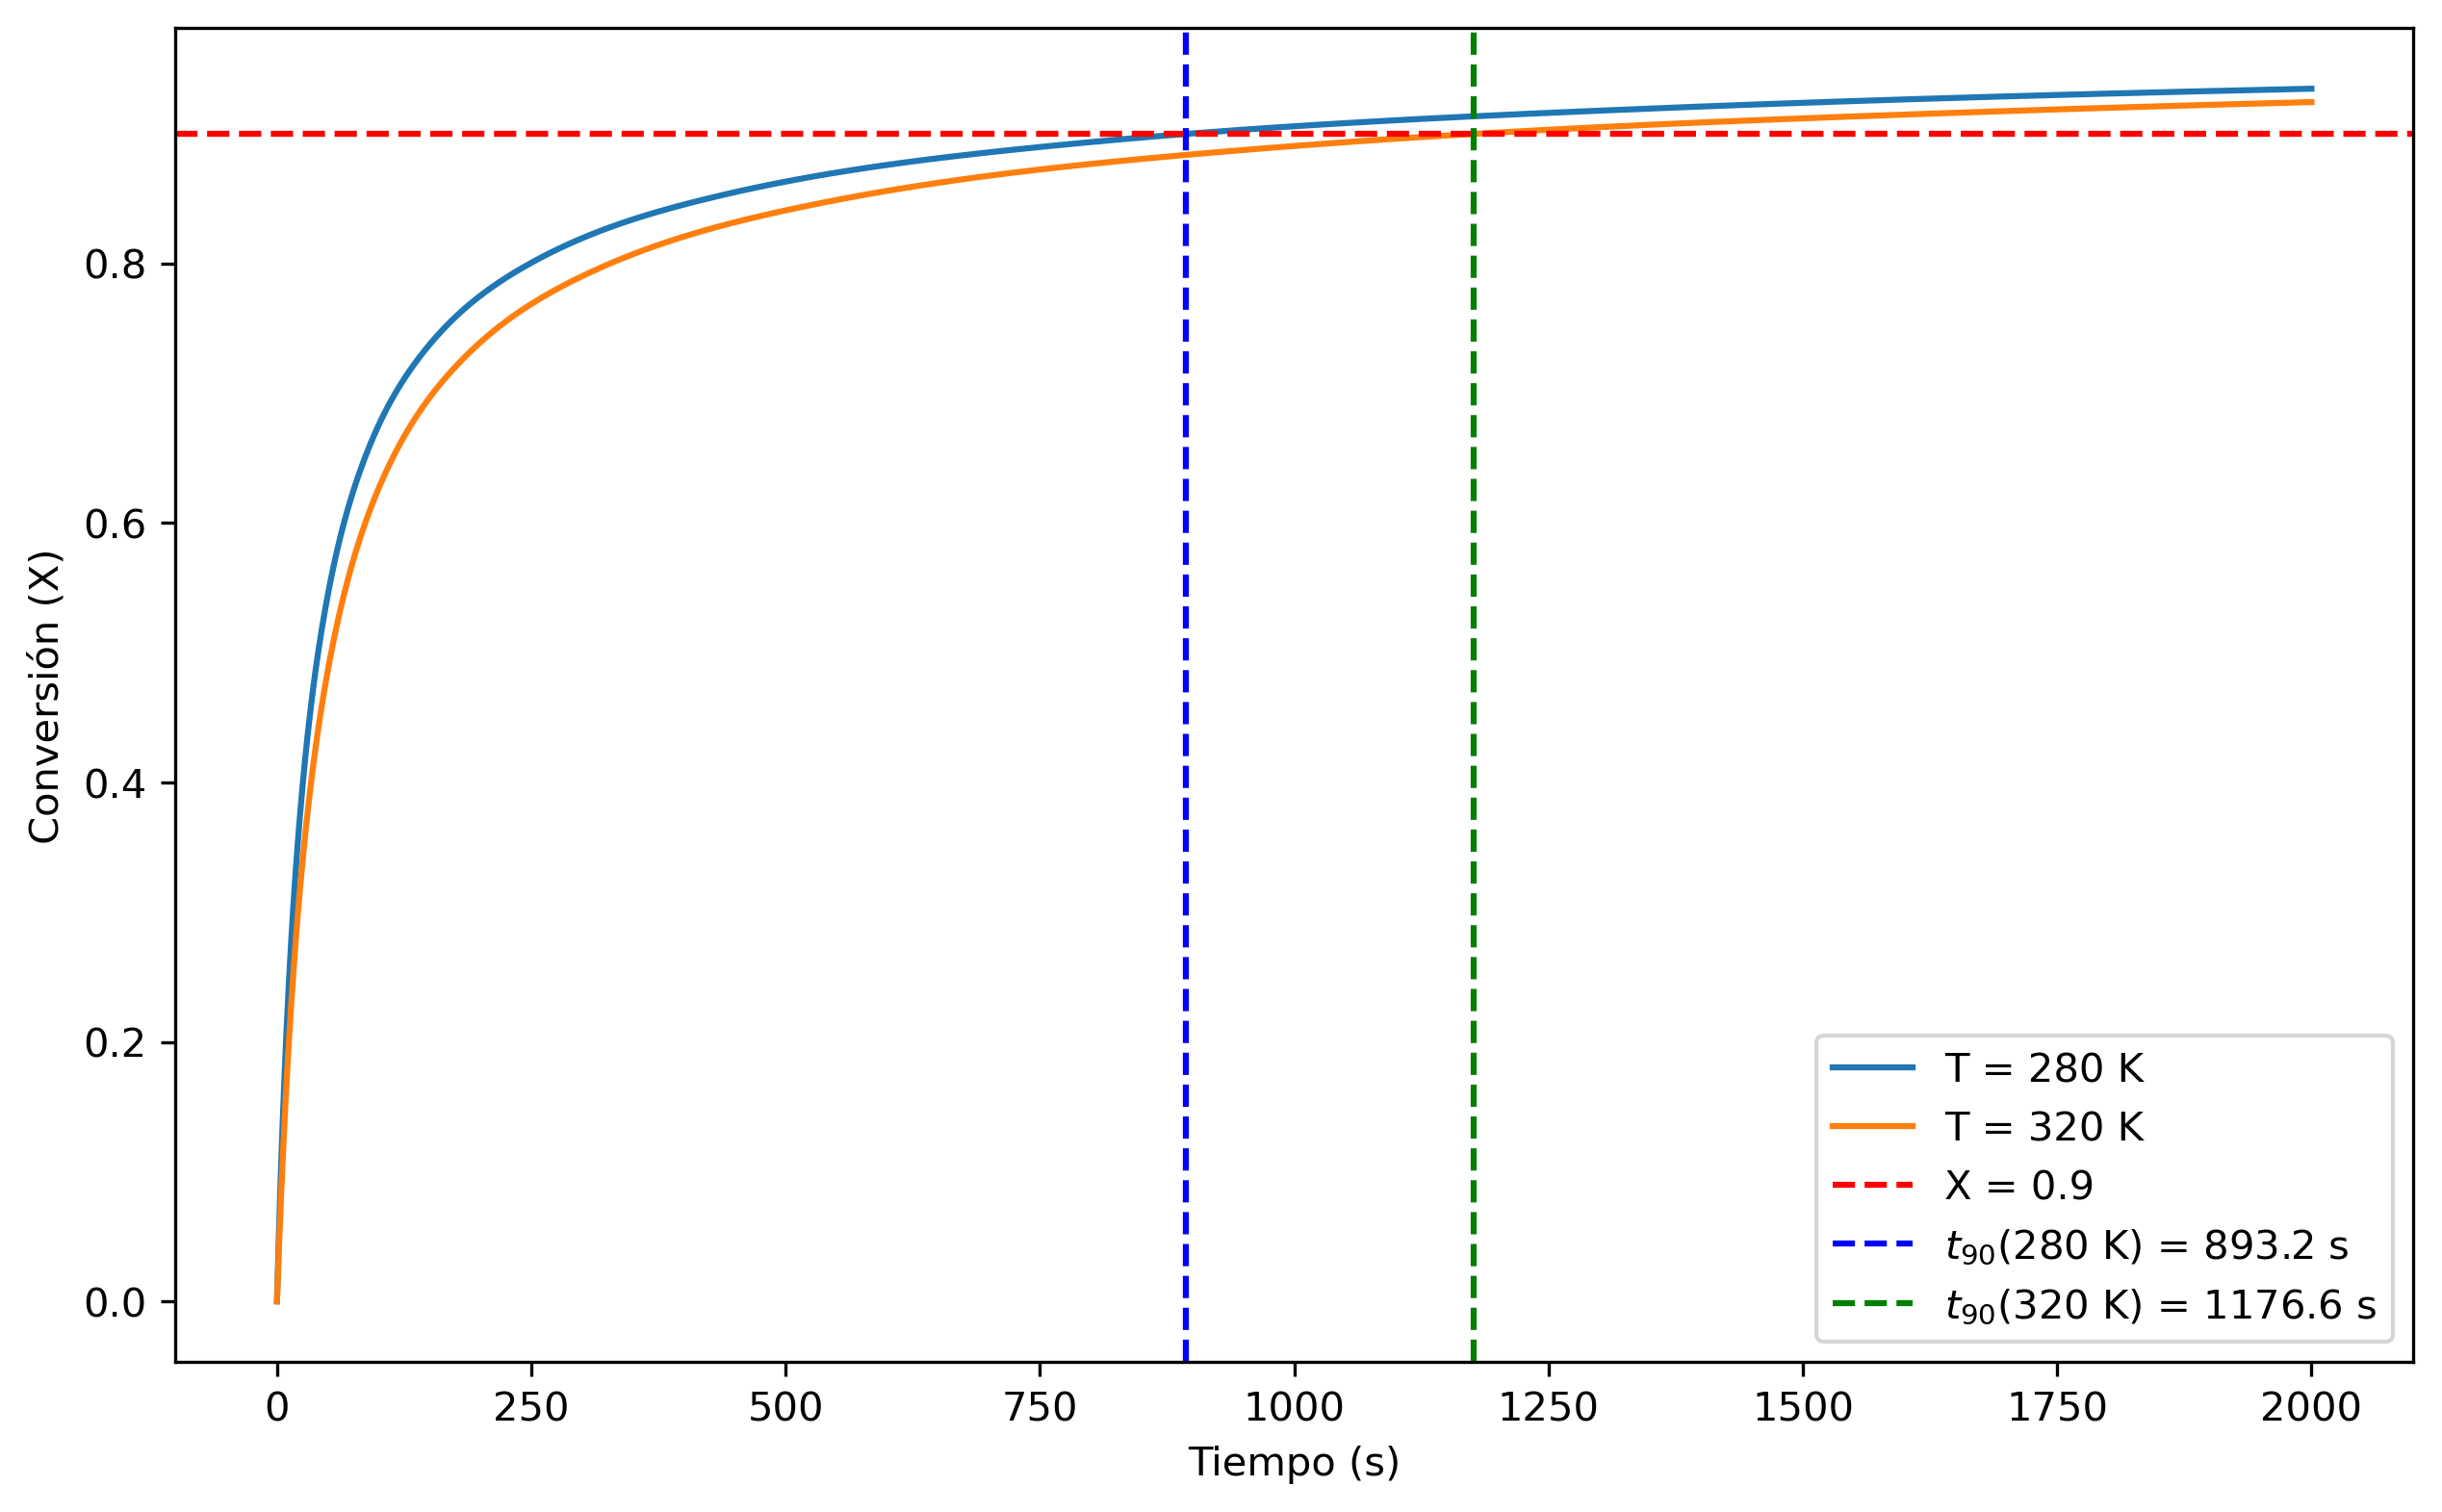

In [ ]:
def dX_dt(t, X, k):
    # la forma en la que sera computado es por temas pedagogicos
    # en cada paso se multiplica por cada termino para explicar
    # tiene el mismo efecto que
    # dXNO_dt = k * CNO_0^2 * (1 - XNO)^3 * (1 - e*XNO)^-2
    dXNO_dt =  k # constante cinética
    dXNO_dt = dXNO_dt * 0.002 ** 2 # CNO_0 ^ 2
    dXNO_dt = dXNO_dt * (1 - X) ** 3 # (1 - X)^3
    dXNO_dt = dXNO_dt * (1 + (-1/3) * X) ** (-2) # (1 - e*X)^-2
    return [dXNO_dt]

def integral_rxn(X, k):
    
    # devolvemos el la expresion que esta dentro de la intgral, es decir
    # int_a^b (1+ε_NO X_NO )^2/(1-X_NO )^3   1/(k C_(NO,0)^2 ) dX_NO
    return ((1 + (-1/3) * X) ** 2) / ((1 - X) ** 3) * (1 / (k * 0.002 ** 2))

t_span = (0,2000)
X0 = [0] # conversion incial
t_eval = np.linspace(t_span[0], t_span[1], 100000) # generamos muchos tiempos para encontrar t90 con mayor presicion

k_280 = constante_velocidad(280, A, Ea, R)

sol_280 = solve_ivp(dX_dt, 
                    t_span,
                    X0, 
                    args=(k_280,), 
                    t_eval=t_eval, 
                    method = 'RK45')
k_320 = constante_velocidad(320, A, Ea, R)

sol_320 = solve_ivp(dX_dt, 
                    t_span,
                    X0, 
                    args=(k_320,), 
                    t_eval=t_eval, 
                    method = 'RK45')
# buscamos el t_90 para alcanzar un X 90


t_90_280 = quad(
    lambda x_no: integral_rxn(x_no, k_280), # notar que aquí se usa lambda function para pasar los argumentos 
    0, 0.9
)[0]
t_90_320 = quad(
    lambda x_no: integral_rxn(x_no, k_320), # notar que aquí se usa lambda function para pasar los argumentos 
    0, 0.9
)[0]
plt.figure(figsize=(10, 6), # tamaño de la figura
             dpi=300)
plt.plot(sol_280.t, sol_280.y[0], label='T = 280 K')
plt.plot(sol_320.t, sol_320.y[0], label='T = 320 K')
plt.axhline(0.9, color='r', linestyle='--', label='X = 0.9')
plt.axvline(t_90_280, color='b', linestyle='--', label=r'$t_{90}$(280 K)' + f' = {t_90_280:.1f} s')
plt.axvline(t_90_320, color='g', linestyle='--', label=r'$t_{90}$(320 K)' + f' = {t_90_320:.1f} s')
plt.xlabel('Tiempo (s)')
plt.ylabel('Conversión (X)')
plt.legend()

## B. ii)

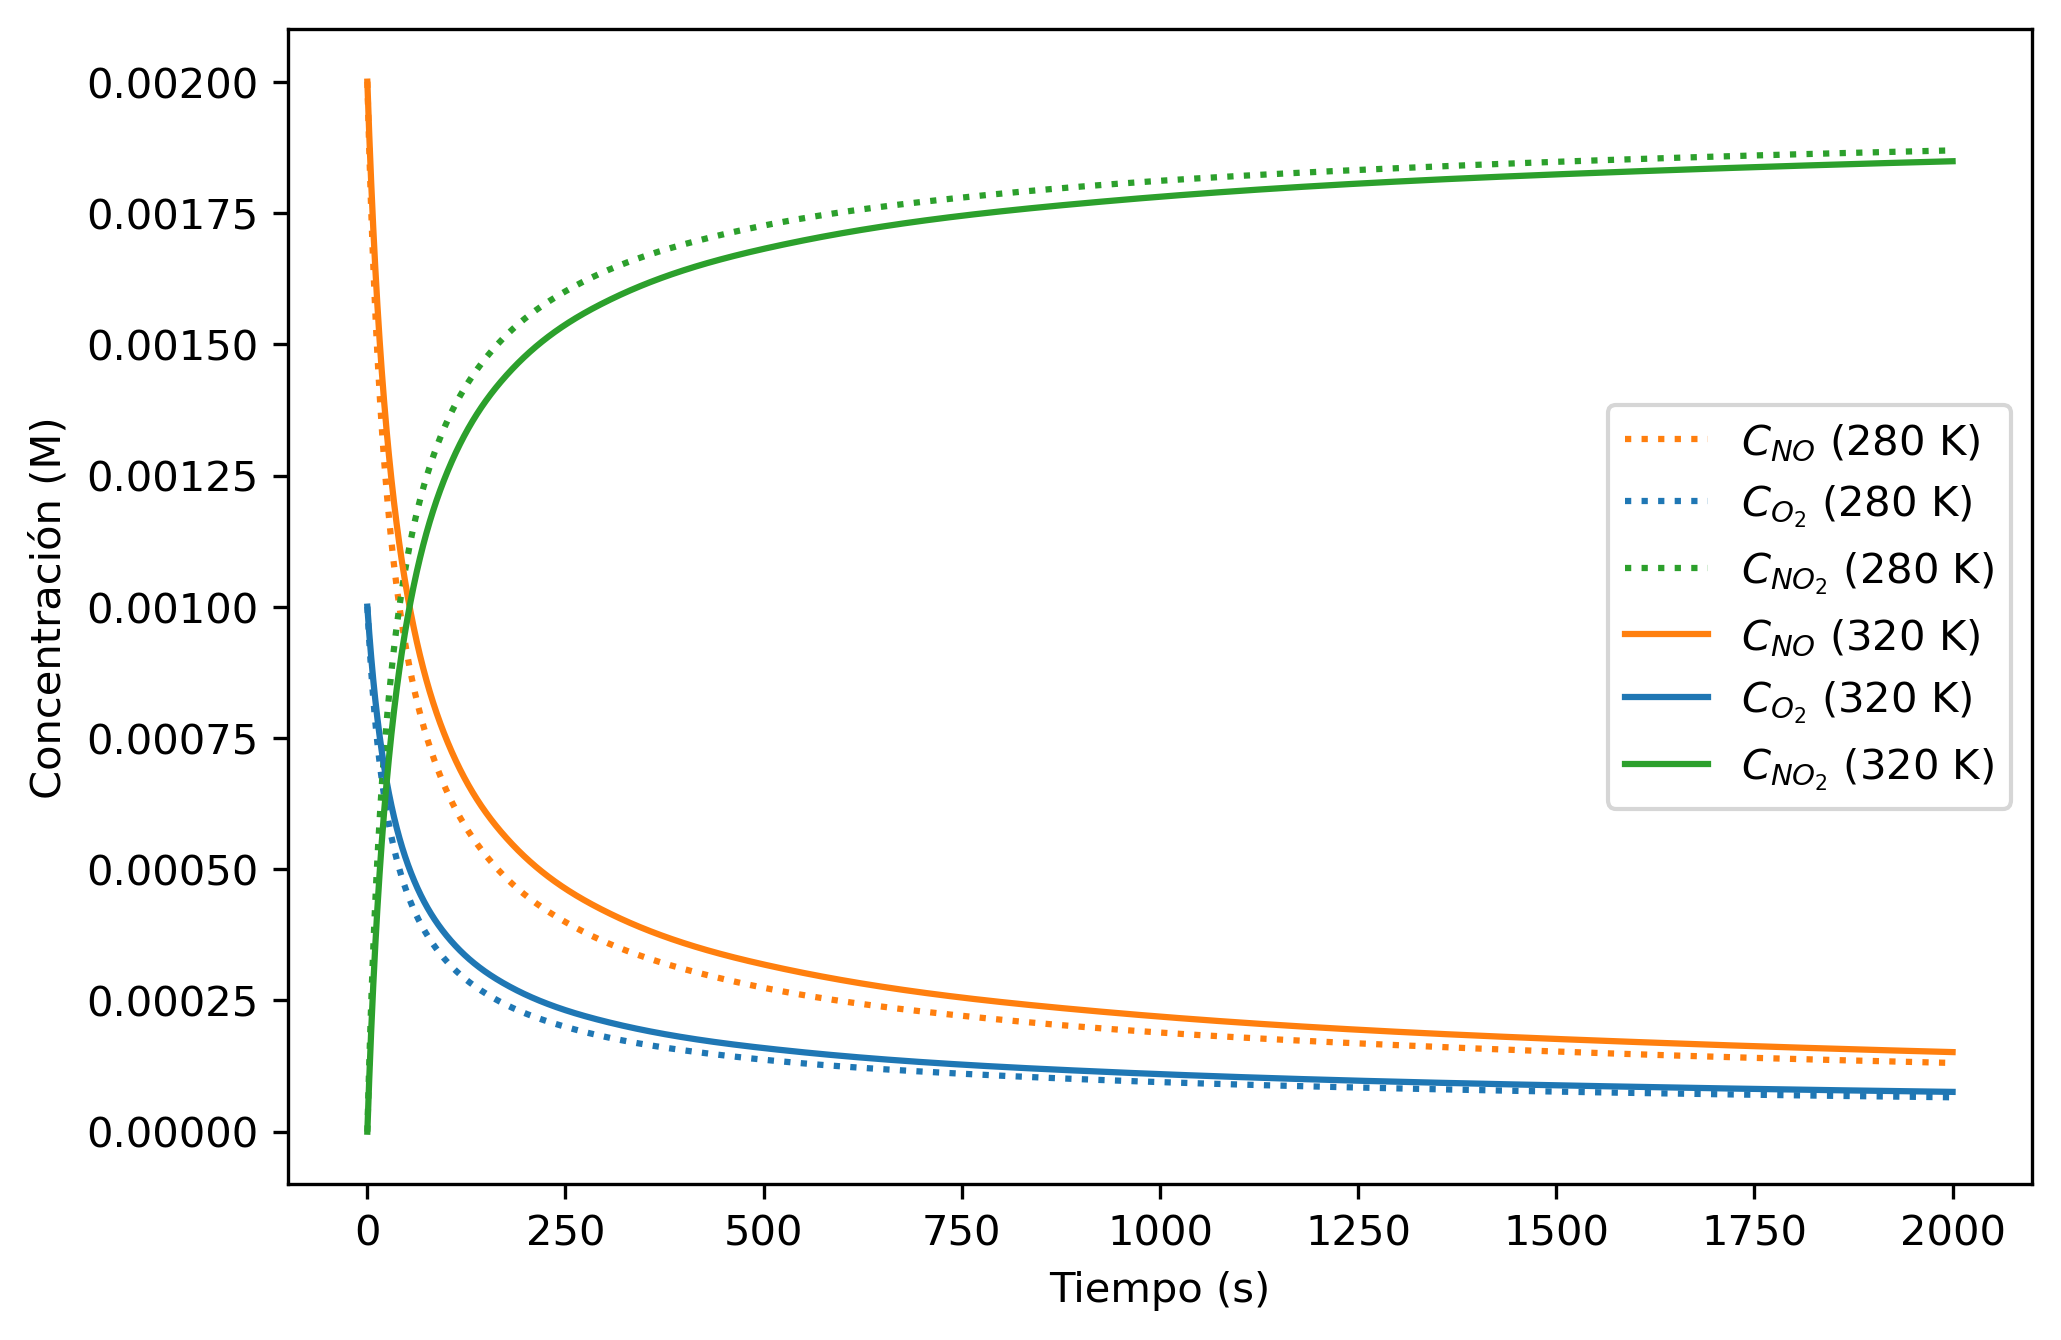

In [ ]:
x_NO_280 = sol_280.y[0]


#### concentraciones
cNO0 = 0.002
epsilon_no = -1/3
cO20 = 0.001
c_NO_280 = cNO0 * (1-x_NO_280)/(1+epsilon_no * cO20)
c_O2_280 = cO20 * (1-x_NO_280)/(1+epsilon_no * cO20)
c_NO2_280 = cNO0 * (x_NO_280) / (1+epsilon_no * cO20)

x_NO_320 = sol_320.y[0]
c_NO_320 = cNO0 * (1-x_NO_320)/(1+epsilon_no * cO20)
c_O2_320 = cO20 * (1-x_NO_320)/(1+epsilon_no * cO20)
c_NO2_320 = cNO0 * (x_NO_320) / (1+epsilon_no * cO20)

plt.figure(figsize=(7.5, 5), # tamaño de la figura
            dpi=300)

plt.plot(sol_280.t, c_NO_280, label=r'$C_{NO}$ (280 K)', color = 'tab:orange', linestyle=':')
plt.plot(sol_280.t, c_O2_280, label=r'$C_{O_2}$ (280 K)', color = 'tab:blue', linestyle=':')
plt.plot(sol_280.t, c_NO2_280, label=r'$C_{NO_2}$ (280 K)', color = 'tab:green', linestyle=':')
plt.xlabel('Tiempo (s)')
plt.ylabel('Concentración (M)')
plt.plot(sol_320.t, c_NO_320, label=r'$C_{NO}$ (320 K)', color='tab:orange', linestyle='-')
plt.plot(sol_320.t, c_O2_320, label=r'$C_{O_2}$ (320 K)', color='tab:blue', linestyle='-')
plt.plot(sol_320.t, c_NO2_320, label=r'$C_{NO_2}$ (320 K)', color='tab:green', linestyle='-')
plt.xlabel('Tiempo (s)')
plt.ylabel('Concentración (M)')
plt.legend()

## B. iii)

In [ ]:
# 3 minutos son 180 segundos

t_span = (0, 180)
X0 = [0]
sol_280 = solve_ivp(dX_dt, 
                    t_span,
                    X0, 
                    args=(k_280,),
                    method = 'LSODA')
X_280_3min = sol_280.y[0][-1]
sol_320 = solve_ivp(dX_dt,
                    t_span,
                    X0,
                    args=(k_320,),
                    method = 'LSODA')
X_320_3min = sol_320.y[0][-1]

print('Conversion a 280 K en 3 minutos:', X_280_3min)
print('Conversion a 320 K en 3 minutos:', X_320_3min)

Conversion a 280 K en 3 minutos: 0.7621739317582041
Conversion a 320 K en 3 minutos: 0.7245290394645887


## c)

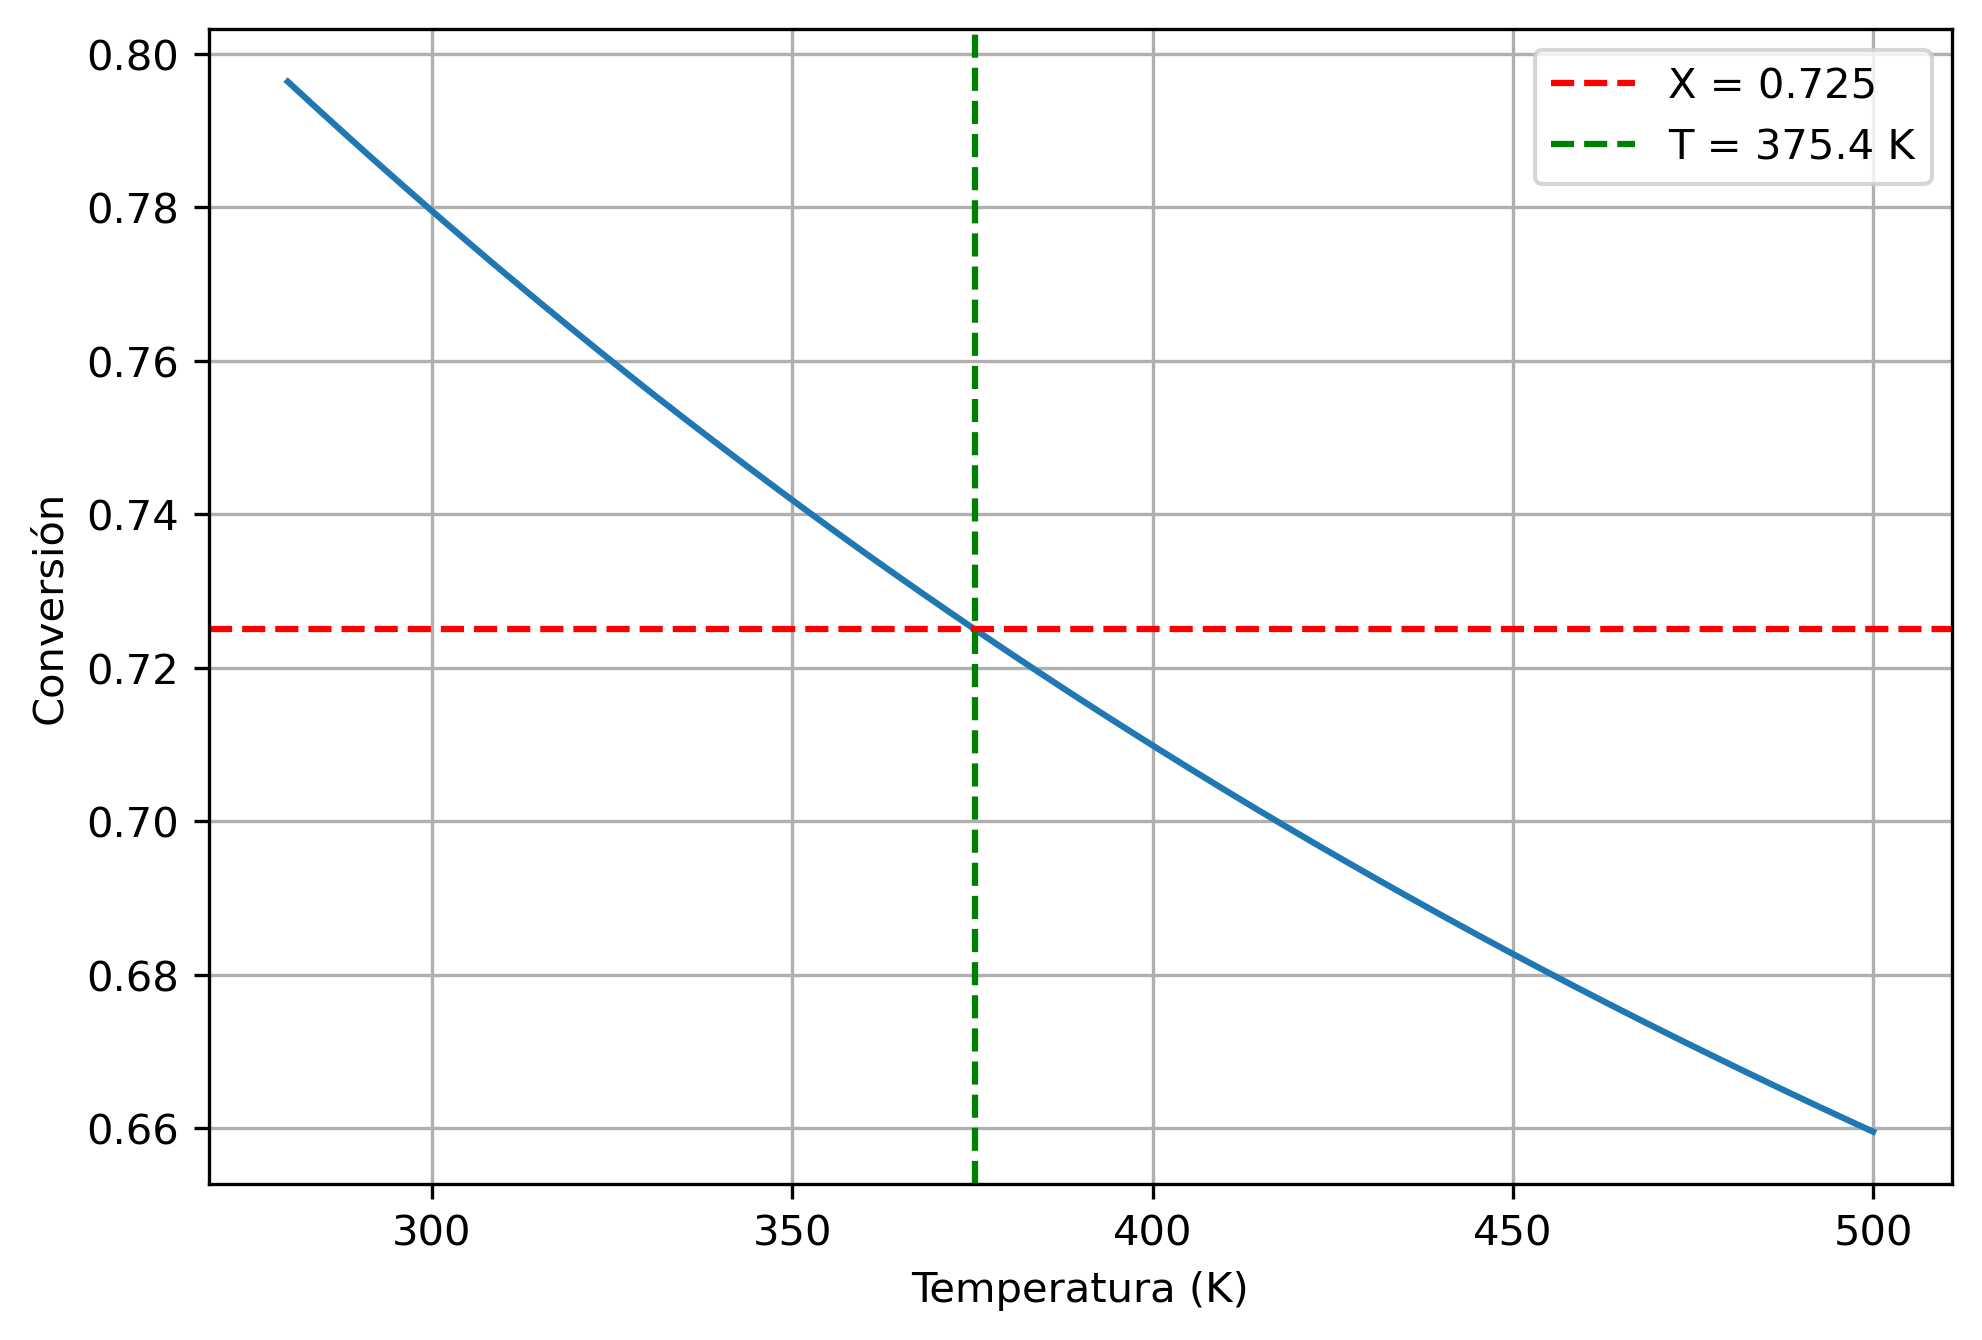

In [ ]:
T = np.linspace(280, 500, 1000) # tomamos 1000 puntos para la temperatura y su presicion
t_span = (0, 4 * 60) # 4 minutos
conversiones = []
temperatura_0725 = 0
for temp in T: # iteramos por las temperaturas
    k = constante_velocidad(temp, A, Ea, R) # constante de velocidad a la temperatura de iteracion
    sol = solve_ivp(dX_dt, t_span, X0, args=(k,), method='LSODA')
    X_4min = sol.y[0][-1] # sacando el ultimo se tiene a los 4 minutos
    conversiones.append(X_4min)
    if np.abs(X_4min - 0.725) < 1e-4:
        temperatura_0725 = temp # cuando la encontramos la guardamos

# graficamos para analizar los resultados

plt.figure(figsize=(7.5, 5), # tamaño de la figura
           dpi = 300)
plt.plot(T, conversiones)
plt.xlabel('Temperatura (K)')
plt.ylabel('Conversión')
plt.axhline(0.725, color='r', linestyle='--', label='X = 0.725')
plt.axvline(temperatura_0725, color='g', linestyle='--', label='T = {:.1f} K'.format(temperatura_0725))
plt.legend()
plt.grid()
plt.show()


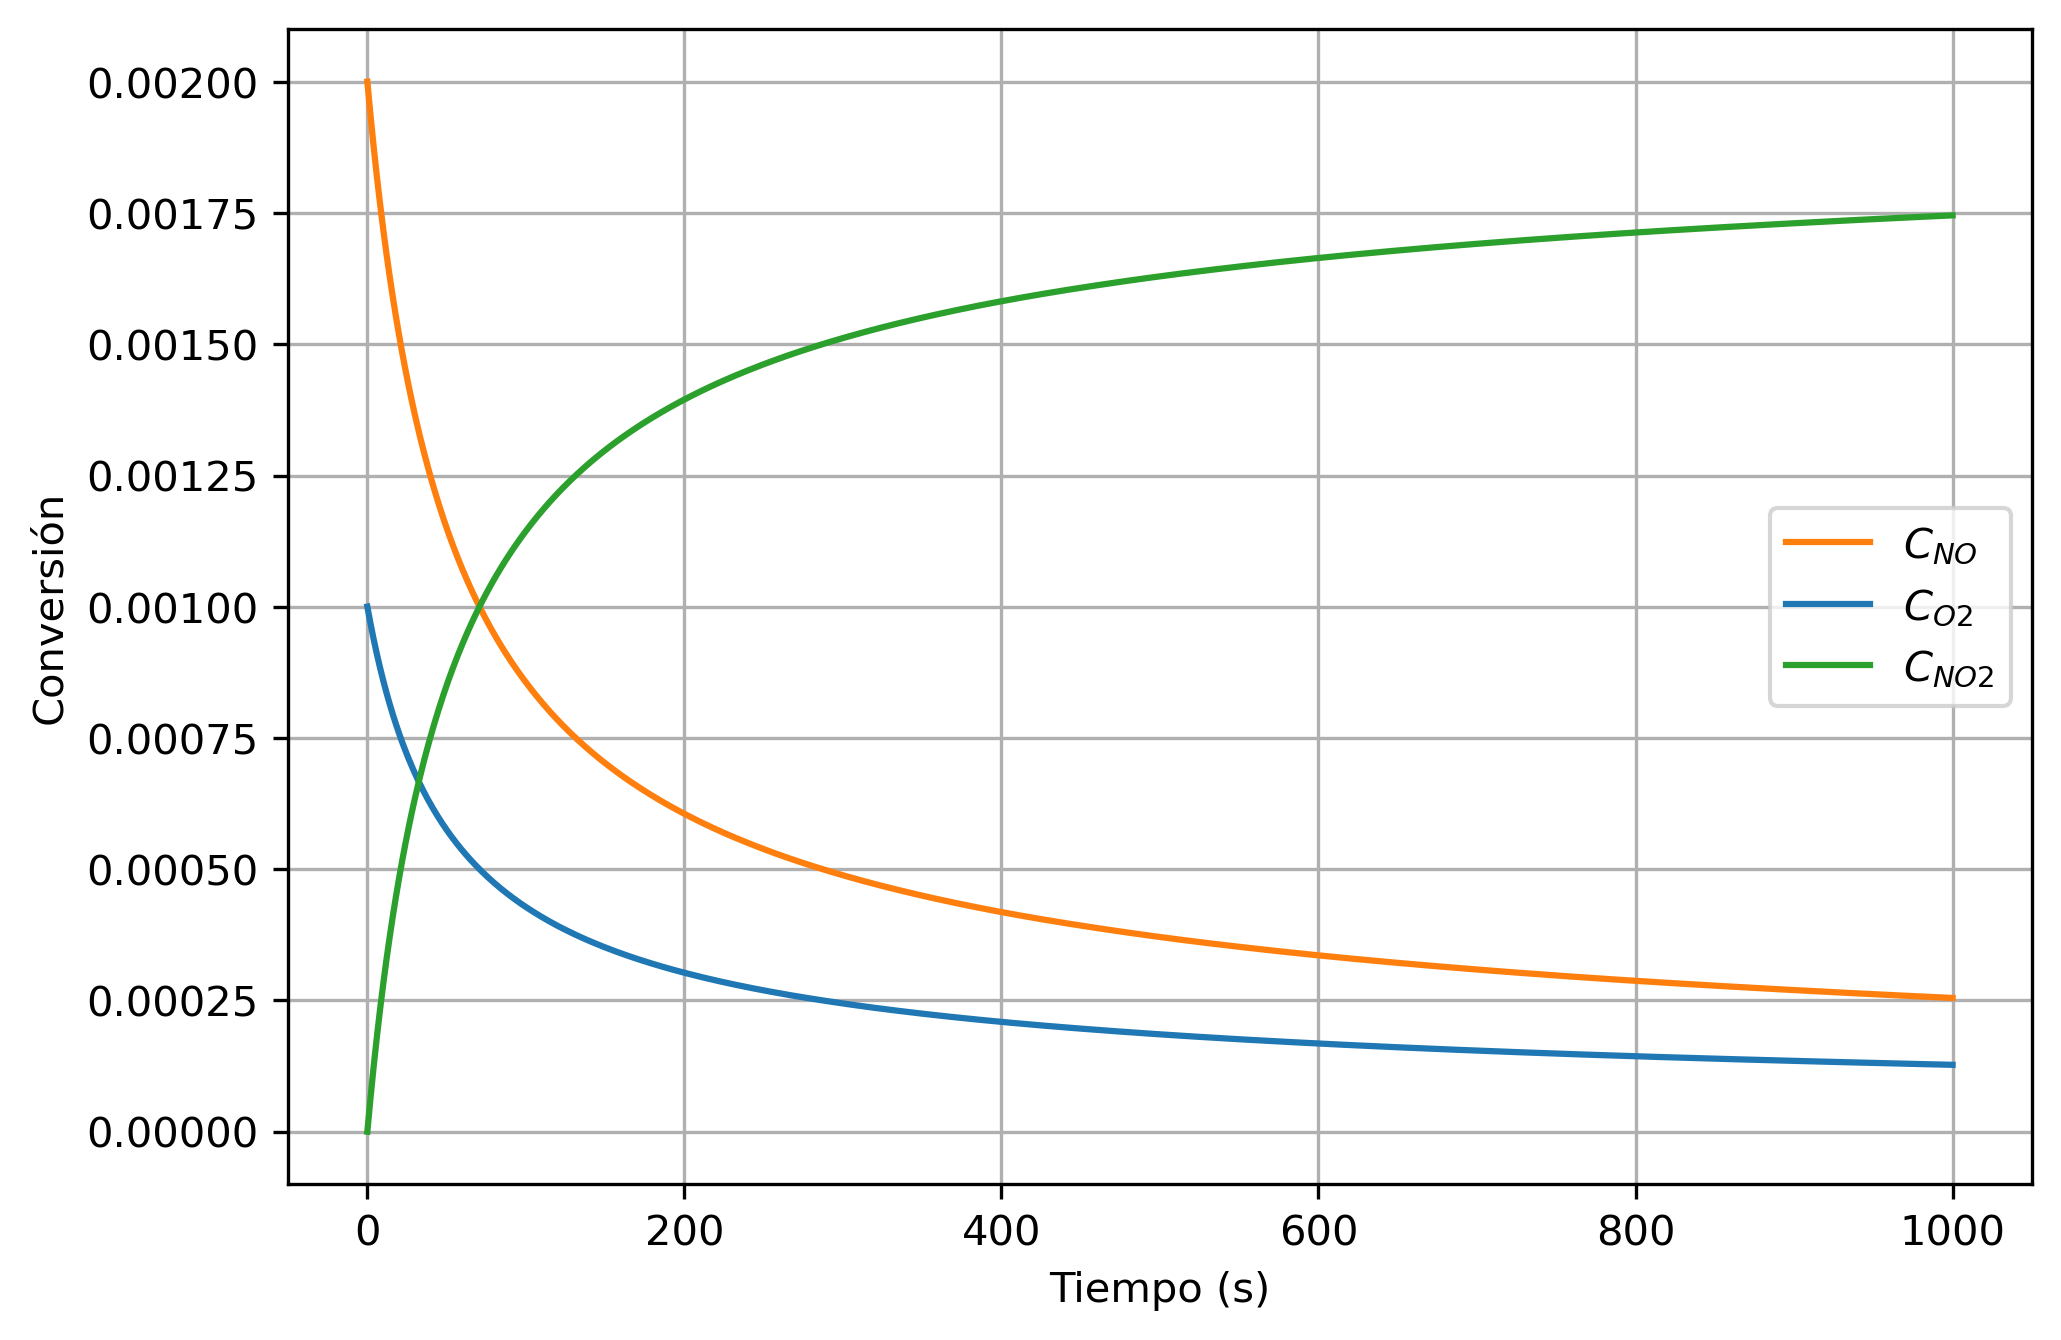

In [ ]:
k_375_4 = constante_velocidad(temperatura_0725, A, Ea, R) # k a la temperatura obtenida previamente
t_span = (0, 1000)
t_eval = np.linspace(t_span[0], t_span[1], 1000)
X0 = [0]
x_no = solve_ivp(dX_dt,
                 t_span,
                 X0,
                 args=(k_375_4,),
                 method='LSODA',
                 t_eval=t_eval)

x_NO = x_no.y[0]


#### concentraciones
cNO0 = 0.002
epsilon_no = -1/3
cO20 = 0.001
c_NO = cNO0 * (1-x_NO)/(1+epsilon_no * cO20)
c_O2 = cO20 * (1-x_NO)/(1+epsilon_no * cO20)
c_NO2 = cNO0 * (x_NO) / (1+epsilon_no * cO20)

plt.figure(figsize=(7.5, 5), # tamaño de la figura
           dpi = 300)
plt.plot(x_no.t, c_NO, label=r'$C_{NO}$', color = 'tab:orange', linestyle='-')
plt.plot(x_no.t, c_O2, label=r'$C_{O2}$', color = 'tab:blue', linestyle='-')
plt.plot(x_no.t, c_NO2, label=r'$C_{NO2}$', color = 'tab:green', linestyle='-')
plt.xlabel('Tiempo (s)')
plt.ylabel('Conversión')
plt.legend()
plt.grid()
plt.show()


# Pregunta 3

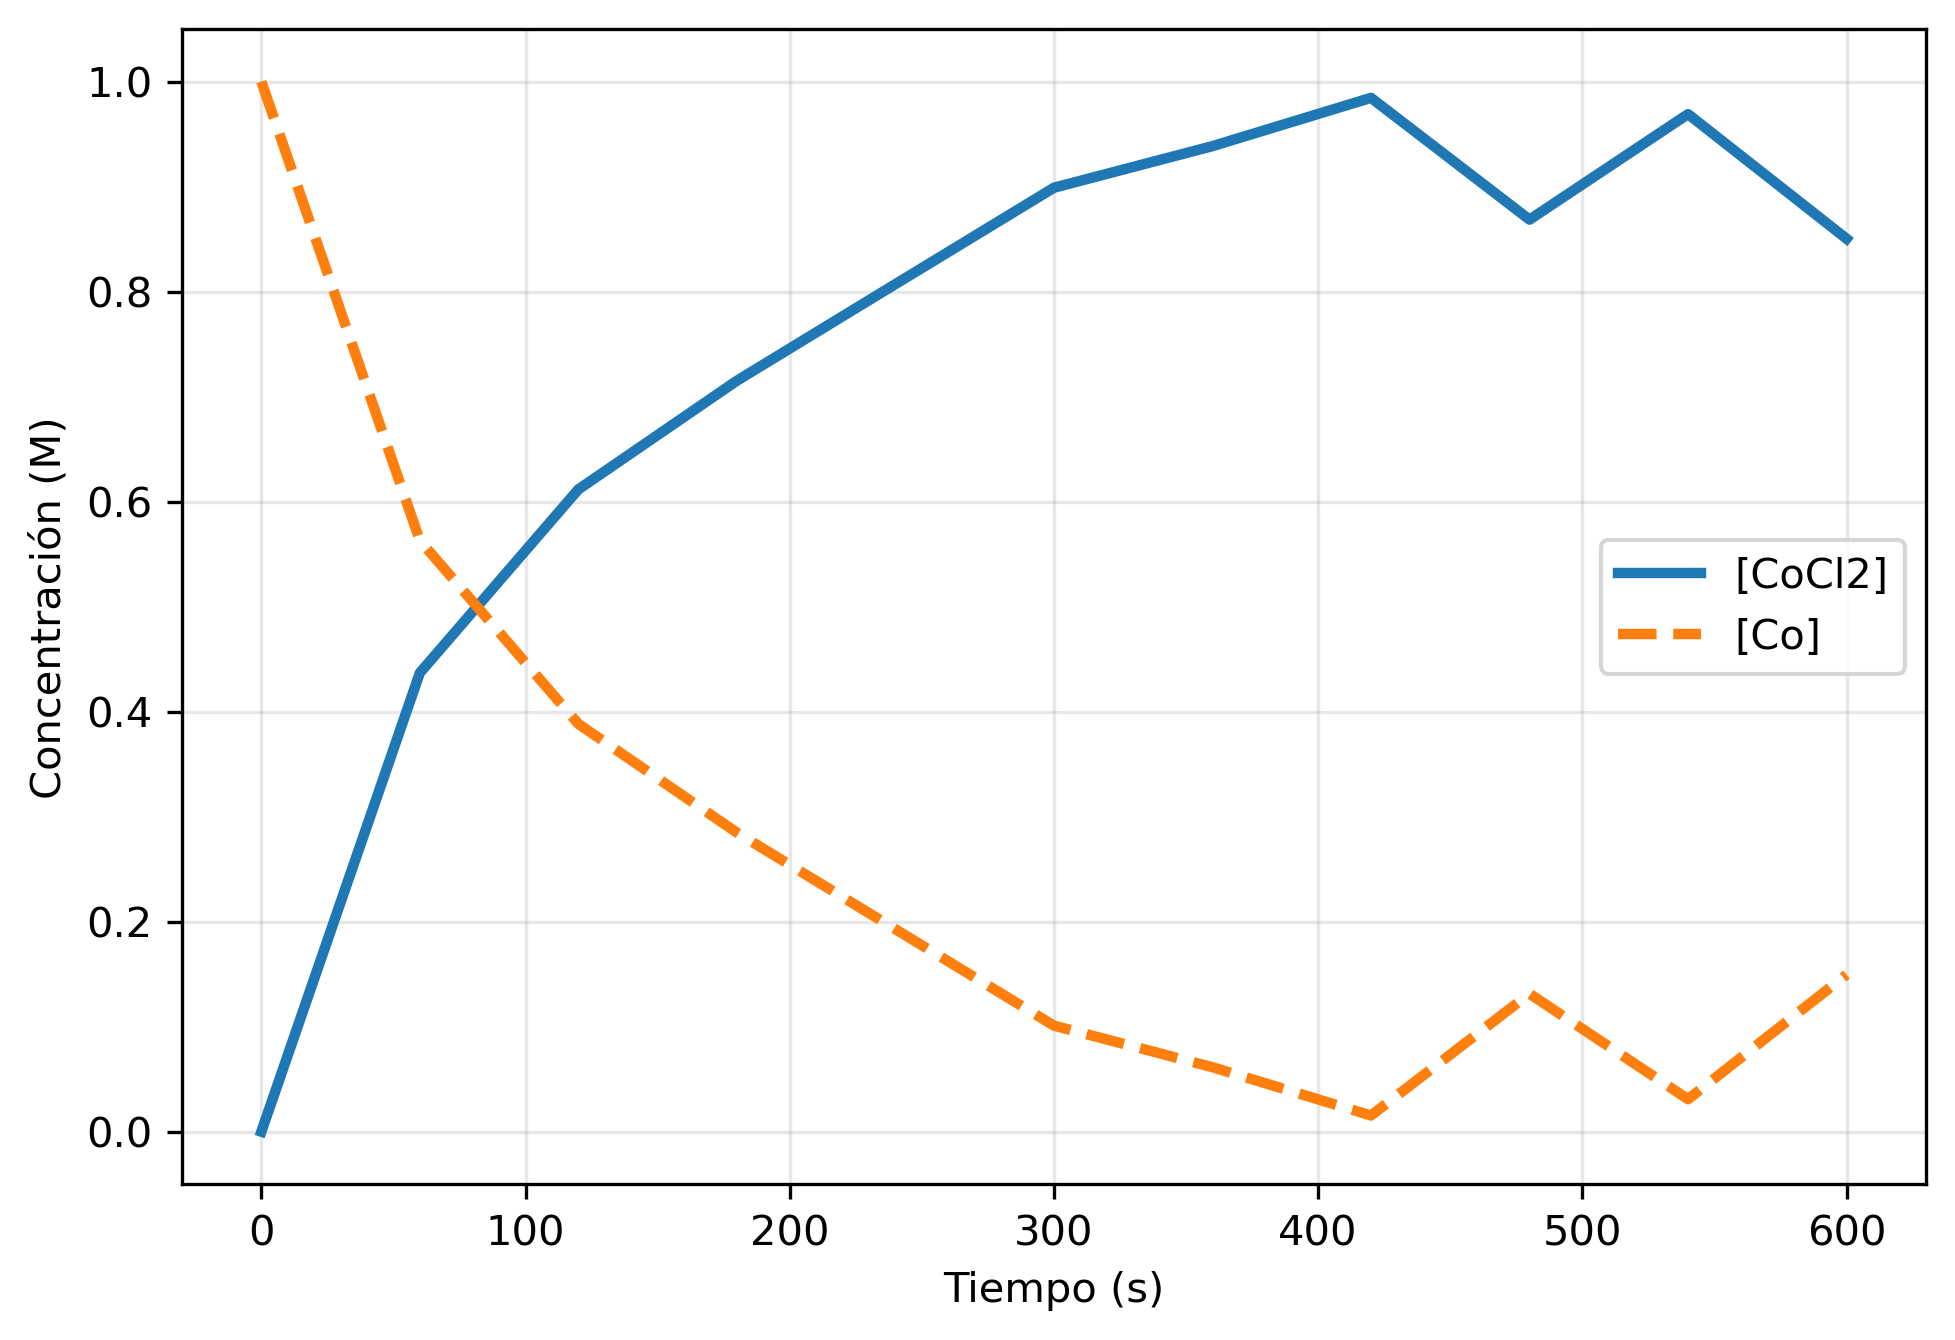

In [15]:
t_data = np.array([0, 60, 120, 180, 240, 300, 360, 420, 480, 540, 600]) # min -> s
cocl2_data = np.array([0, 0.4370, 0.6117, 0.7152, 0.8072, 0.8990, 0.9386, 0.9846, 0.8686, 0.9691, 0.8504]) # M
co0 = 1 # M
co_data =  co0 - cocl2_data

# primer gráfico
plt.figure(figsize=(7.5, 5), dpi=300)
plt.grid(True, alpha=0.3)

# graficamos los datos
plt.plot(t_data, cocl2_data, label='[CoCl2]', linestyle='-', color='tab:blue', linewidth=2.5)
plt.plot(t_data, co_data, label='[Co]', linestyle='--', color='tab:orange', linewidth=2.5)
# etiquetas de los ejes
plt.xlabel('Tiempo (s)')
plt.ylabel('Concentración (M)')
# leyenda
plt.legend()
# mostramos
plt.show()




In [62]:
c0_co = 1
def dCOdt(t, co, k, n): 
    '''
    Sistema de ecuaciones diferenciales para la reacción 
    CO + Cl2 -> COCl2.
    k -> constante cinetica
    n -> coeficiente 
    '''
    dcodt = - k * co ** n
    return [dcodt]


def y_data_curvefit(t_data, *params):
    k, n = params
    c0 = [c0_co]  # Ensure this is a list of length 1 (not an array of shape (2,))
    
    t_span = (min(t_data), max(t_data))
    sol = solve_ivp(
        dCOdt, # Sistema de ecuaciones diferenciales
        t_span, # Intervalo de tiempo de integracion
        c0, # condiciones iniciales
        args=(k, n), # argumentos del sistema de ecuaciones diferenciales
        t_eval=t_data, # tiempo en cual sacar datos
        method='RK45' # método de integración
    )
    
    
    return sol.y[0].reshape(-1)


popt, pcov = curve_fit(y_data_curvefit, t_data, co_data, p0=[0.01, 1],  # Valores iniciales k y alpha
                       bounds=([0.00001,0.1],  # k_lb, n_lb
                                [np.inf, np.inf]  # k_ub, n_ub
                                )
                       )
print('Parámetros ajustados:')
print(f'k = {popt[0]}')
print(f'n = {popt[1]}')

Parámetros ajustados:
k = 0.01036286572749698
n = 1.431321430951354


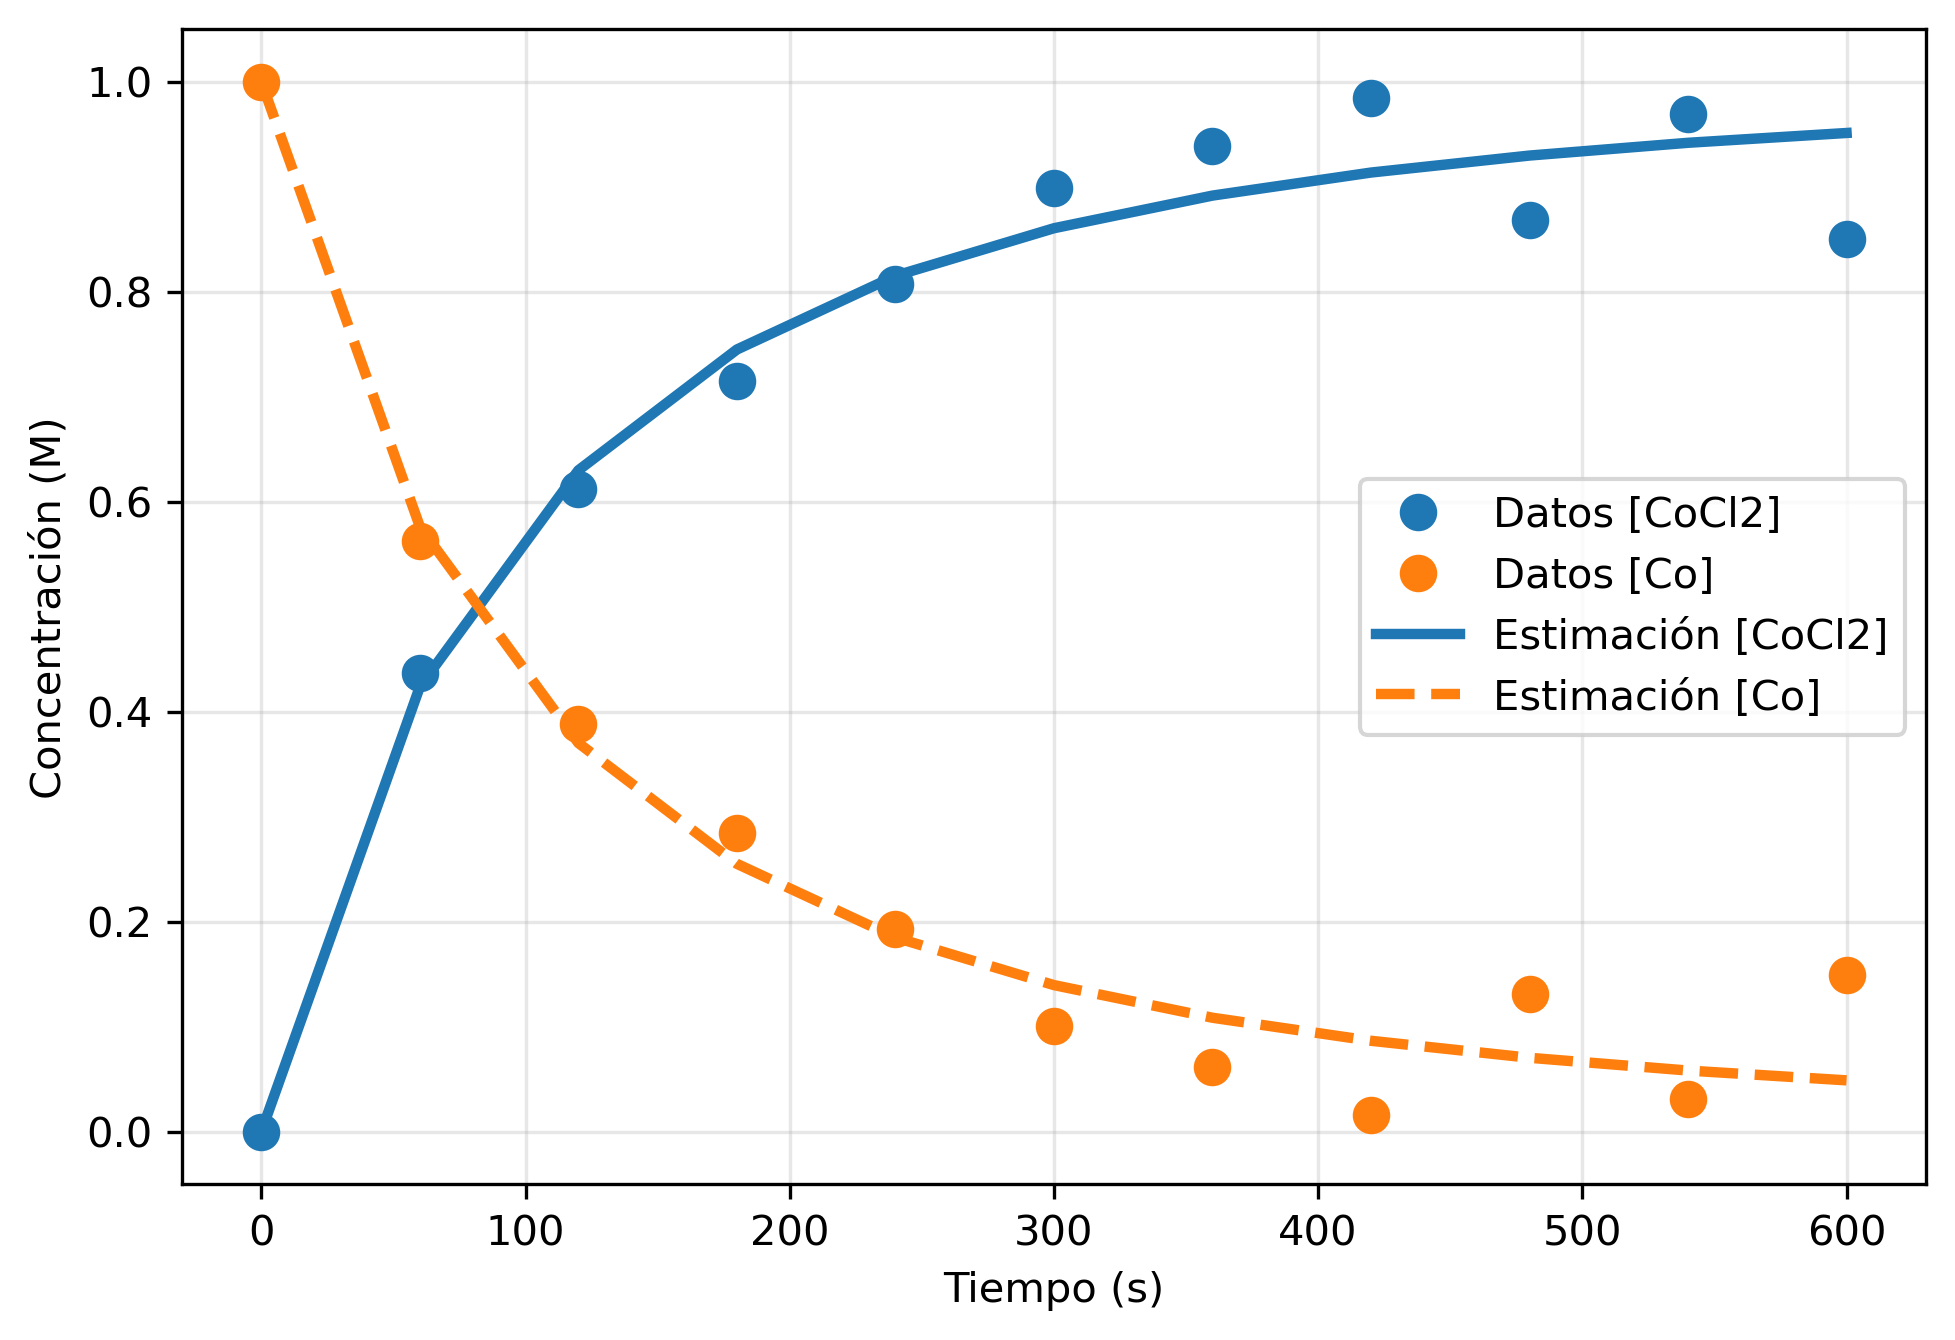

In [63]:
k, n = popt

estimation = solve_ivp(
    dCOdt,
    (min(t_data), max(t_data)),
    y0 = [co0],
    args=(k, n),
    t_eval=t_data
)

co_estimated = estimation.y[0]
cocl2_estimated = co0 - co_estimated

plt.figure(figsize=(7.5, 5), dpi=300)
plt.grid(True, alpha=0.3)
# graficamos los datos
plt.plot(t_data, cocl2_data, 'o', label='Datos [CoCl2]', color='tab:blue', markersize=8)
plt.plot(t_data, co_data, 'o', label='Datos [Co]', color='tab:orange', markersize=8)
# graficamos la estimación
plt.plot(t_data, cocl2_estimated, label='Estimación [CoCl2]', linestyle='-', color='tab:blue', linewidth=2.5)
plt.plot(t_data , co_estimated, label='Estimación [Co]', linestyle='--', color='tab:orange', linewidth=2.5)
# etiquetas de los ejes
plt.xlabel('Tiempo (s)')
plt.ylabel('Concentración (M)')
# leyenda
plt.legend()